In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy as sp
import faraway.utils

In [4]:
import faraway.datasets.cheddar
cheddar = faraway.datasets.cheddar.load()
cheddar.head()

,taste,Acetic,H2S,Lactic
0,12.3,4.543,3.135,0.86
1,20.9,5.159,5.043,1.53
2,39.0,5.366,5.438,1.57
3,47.9,5.759,7.496,1.81
4,5.6,4.663,3.807,0.99


            coefs stderr tvalues pvalues
Intercept -61.499 24.846   -2.48  0.0196
Acetic     15.648  4.496    3.48  0.0017

n=30 p=2 Residual SD=13.821 R-squared=0.30


<AxesSubplot:xlabel='Acetic', ylabel='taste'>

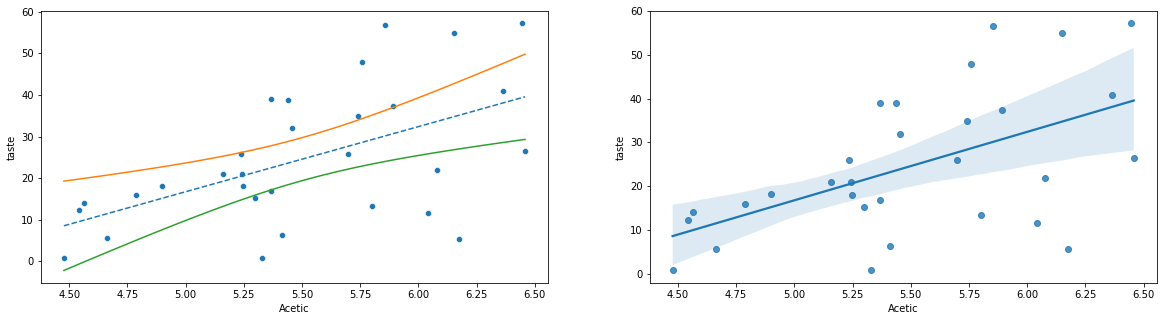

In [5]:
f, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.scatterplot(x="Acetic", y="taste", data=cheddar, ax=ax[0])
ac_lmod = smf.ols("taste ~ Acetic", data=cheddar).fit() 
ac_lmod.sumary()
b0, b1 = ac_lmod.params
ix = pd.DataFrame({"Acetic": np.linspace(
    cheddar["Acetic"].min(),
    cheddar["Acetic"].max(), 
    num=100
)}) 
ax[0].plot(
    [cheddar["Acetic"].min(), cheddar["Acetic"].max()],
    [b0 + b1*cheddar["Acetic"].min(), b0 + b1*cheddar["Acetic"].max()],
    ls='--'
)
conf_ints = ac_lmod.get_prediction(ix).conf_int()
l = conf_ints[:, 0]
u = conf_ints[:, 1]

ax[0].plot(ix, u)
ax[0].plot(ix, l)

sns.regplot(x="Acetic", y="taste", data=cheddar, ax=ax[1])

In [6]:
import faraway.utils
lmod = smf.ols(
    "taste ~ Acetic + H2S + Lactic",
    data=cheddar
).fit()
lmod.sumary()

            coefs stderr tvalues pvalues
Intercept -28.877 19.735   -1.46  0.1554
Acetic      0.328  4.460    0.07  0.9420
H2S         3.912  1.248    3.13  0.0042
Lactic     19.671  8.629    2.28  0.0311

n=30 p=4 Residual SD=10.131 R-squared=0.65


(x            3.277413e-01
 Intercept    1.054712e-14
 dtype: float64,
 x            15.647767
 Intercept   -61.498612
 dtype: float64)

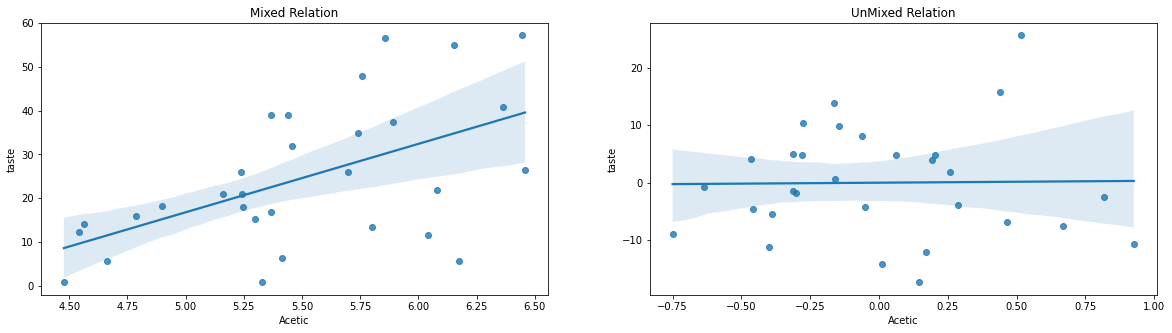

In [7]:

f, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.regplot(x="Acetic", y="taste", data=cheddar, ax=ax[0])
ax[0].set_title("Mixed Relation")

# added variable (or partial regression) plot
unmixed_x = smf.ols("Acetic ~ H2S + Lactic", data=cheddar).fit().resid
unmixed_y = smf.ols("taste ~ H2S + Lactic", data=cheddar).fit().resid
ax[1].set_title("UnMixed Relation")
sns.regplot(x=unmixed_x, y=unmixed_y, data=cheddar, ax=ax[1])
ax[1].set_xlabel("Acetic")
ax[1].set_ylabel("taste")

(
    sm.OLS(
        unmixed_y, 
        pd.DataFrame({"x": unmixed_x, "Intercept": 1})
    ).fit().params,
    sm.OLS(
        cheddar["taste"], 
        pd.DataFrame({"x": cheddar["Acetic"], "Intercept": 1})
    ).fit().params
)

(x            5.776089
 Intercept   -9.786837
 dtype: float64,
 x            3.911841e+00
 Intercept   -5.884182e-15
 dtype: float64,
 x            3.911841e+00
 Intercept   -4.440892e-16
 dtype: float64)

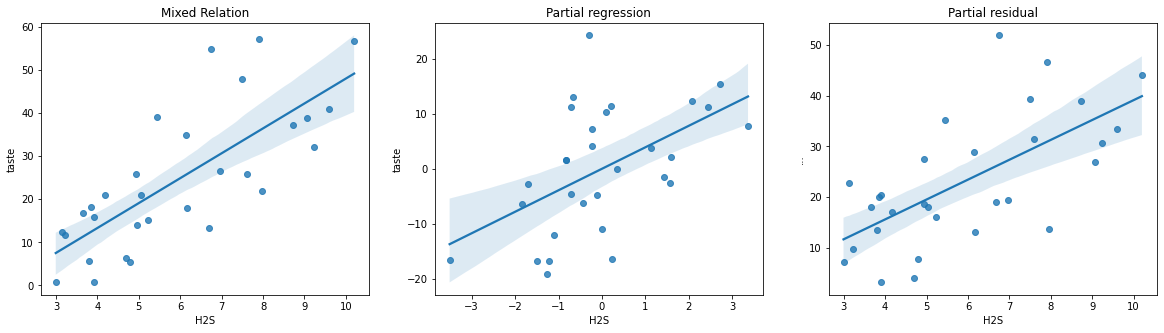

In [8]:
unmixed_x = smf.ols("H2S ~ Acetic + Lactic", data=cheddar).fit().resid
unmixed_y = smf.ols("taste ~ Acetic + Lactic", data=cheddar).fit().resid

f, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].set_title("Mixed Relation")
sns.regplot(x="H2S", y="taste", data=cheddar, ax=ax[0])

ax[1].set_title("Partial regression")
sns.regplot(x=unmixed_x, y=unmixed_y, data=cheddar, ax=ax[1])
ax[1].set_xlabel("H2S")
ax[1].set_ylabel("taste")


ax[2].set_title("Partial residual")
sns.regplot(
    x=cheddar["H2S"], 
    y=lmod.resid + lmod.params["H2S"]*cheddar["H2S"], 
    ax=ax[2]
)
ax[2].set_xlabel("H2S")
ax[2].set_ylabel("...")

(
    sm.OLS(
        cheddar["taste"], 
        pd.DataFrame({"x": cheddar["H2S"], "Intercept": 1})
    ).fit().params,
    sm.OLS(
        unmixed_y, 
        pd.DataFrame({"x": unmixed_x, "Intercept": 1})
    ).fit().params,
    sm.OLS(
        lmod.resid + lmod.params["H2S"]*cheddar["H2S"], 
        pd.DataFrame({"x": cheddar["H2S"], "Intercept": 1})
    ).fit().params,
)

In [9]:
lmod.sumary()

            coefs stderr tvalues pvalues
Intercept -28.877 19.735   -1.46  0.1554
Acetic      0.328  4.460    0.07  0.9420
H2S         3.912  1.248    3.13  0.0042
Lactic     19.671  8.629    2.28  0.0311

n=30 p=4 Residual SD=10.131 R-squared=0.65


full effect coeff: 3.9118410736650437


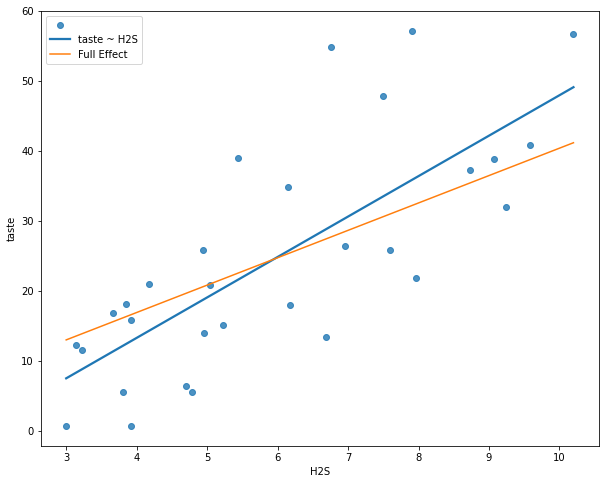

In [27]:
n = cheddar.shape[0]
ix = [cheddar["H2S"].min(), cheddar["H2S"].max()]
X = pd.DataFrame({
    "H2S": ix,
    "Acetic": cheddar["Acetic"].mean(),
    "Lactic": cheddar["Lactic"].mean(),
})
prediction = lmod.get_prediction(X).predicted_mean

f, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.regplot(x="H2S", y="taste", data=cheddar, ax=ax, ci=None) 
ax.plot(ix, prediction)

print("full effect coeff:", (prediction[1] - prediction[0])/(ix[1]-ix[0]))

ax.legend([None, "taste ~ H2S", "Full Effect"])

The slope for the full effect plot is the same as for the partial regression/residual plots

### not really

In [11]:
%run utils.ipynb

In [12]:
lmod.sumary()

            coefs stderr tvalues pvalues
Intercept -28.877 19.735   -1.46  0.1554
Acetic      0.328  4.460    0.07  0.9420
H2S         3.912  1.248    3.13  0.0042
Lactic     19.671  8.629    2.28  0.0311

n=30 p=4 Residual SD=10.131 R-squared=0.65


In [13]:
pvalues = []

for i in range(1000):
    cheddar["Lactic_pertr"] = cheddar["Lactic"] + np.random.normal(scale=0.01, size=cheddar.shape[0])
    pvalues.append(smf.ols(
        "taste ~ Acetic + H2S + Lactic_pertr",
        data=cheddar
    ).fit().pvalues["Lactic_pertr"])
    
pd.DataFrame({"pvals": pvalues}).describe()

,pvals
count,1000.000000
mean,0.031446
std,0.003471
min,0.022870
25%,0.029109
50%,0.031223
75%,0.033545
max,0.043072


In [14]:
pvalues = []

for i in range(1000):
    cheddar["Lactic_pertr"] = cheddar["Lactic"] + np.random.normal(scale=0.1, size=cheddar.shape[0])
    pvalues.append(smf.ols(
        "taste ~ Acetic + H2S + Lactic_pertr",
        data=cheddar
    ).fit().pvalues["Lactic_pertr"])
    
pvalues = pd.DataFrame({"pvals": pvalues})
pvalues.describe()

,pvals
count,1000.000000
mean,0.068043
std,0.066996
min,0.000725
25%,0.023713
50%,0.045505
75%,0.089433
max,0.503594


<AxesSubplot:ylabel='Count'>

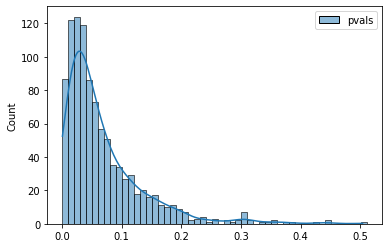

In [15]:
sns.histplot(pvalues, bins=100, binwidth=0.01, kde=True)

In [16]:
pvalues[pvalues < 0.05].count()

pvals    532
dtype: int64

### Robust -- not done

In [17]:
lmod.sumary()

            coefs stderr tvalues pvalues
Intercept -28.877 19.735   -1.46  0.1554
Acetic      0.328  4.460    0.07  0.9420
H2S         3.912  1.248    3.13  0.0042
Lactic     19.671  8.629    2.28  0.0311

n=30 p=4 Residual SD=10.131 R-squared=0.65


In [18]:
cheddar["time"] = cheddar.index

<AxesSubplot:xlabel='time'>

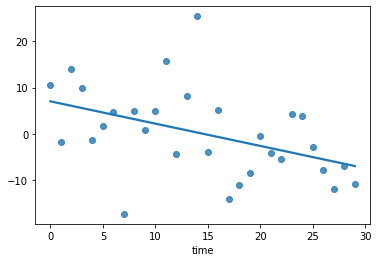

In [19]:
sns.regplot(x=cheddar["time"], y=lmod.resid, ci=None)

In [20]:
lmod.resid.autocorr()

0.17870805401615233

In [21]:
X = pd.DataFrame(lmod.model.wexog, columns=lmod.params.index)
y = lmod.model.wendog
gmod = sm.GLSAR(y, X, rho=1)
res = gmod.iterative_fit(maxiter=6)
gmod.rho.round(2)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.677
Model:                          GLSAR   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     17.47
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           2.51e-06
Time:                        19:07:53   Log-Likelihood:                -105.54
No. Observations:                  29   AIC:                             219.1
Df Residuals:                      25   BIC:                             224.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -35.6887     20.763     -1.719      0.098     -78.450       7.073
Acetic         1.5429      4.735      0.326      0.747      -8.208      11.294
H2S            3.9457      1.289      3.060      0.005       1.290       6.601
Lactic        19.2280      9.166      2.098      0.046       0.351      38.105
==============================================================================
Omnibus:                        1.213   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.545   Jarque-Bera (JB):                0.736
Skew:                           0.390   Prob(JB):                        0.692
Kurtosis:                       2.974   Cond. No.                         82.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
lmod_time = smf.ols("taste ~ Acetic + H2S + Lactic + time", cheddar).fit()
lmod_time.sumary()

            coefs stderr tvalues pvalues
Intercept -37.159 18.018   -2.06  0.0497
Acetic      4.127  4.256    0.97  0.3414
H2S         3.539  1.131    3.13  0.0044
Lactic     17.953  7.788    2.31  0.0297
time       -0.546  0.204   -2.67  0.0131

n=30 p=5 Residual SD=9.112 R-squared=0.73


### Transformations

We will now fit an additive model.

In [32]:
from statsmodels.gam.api import GLMGam, BSplines
xmat = cheddar[['Acetic', 'H2S', 'Lactic']]
bs = BSplines(xmat, df=[4, 4, 4], degree=[3, 3, 3])
gamod = GLMGam.from_formula(
    'taste ~ Acetic + Lactic + H2S', 
    cheddar,
    smoother=bs
).fit()
gamod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  taste   No. Observations:                   30
Model:                         GLMGam   Df Residuals:                    20.00
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               identity   Scale:                          128.71
Method:                         PIRLS   Log-Likelihood:                -109.35
Date:                Sun, 21 Aug 2022   Deviance:                       2574.2
Time:                        19:28:52   Pearson chi2:                 2.57e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7509
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2558      7.263     -0.311      0.756     -16.492      11.980
Acetic        -2.7680      4.362     -0.635      0.526     -11.318       5.782
Lactic         9.9195     12.426      0.798      0.425     -14.436      34.274
H2S            4.0752      1.970      2.068      0.039       0.214       7.937
Acetic_s0     -3.9326     26.683     -0.147      0.883     -56.231      48.366
Acetic_s1      1.1022     15.702      0.070      0.944     -29.674      31.878
Acetic_s2      4.2768     11.523      0.371      0.711     -18.308      26.861
H2S_s0         4.3045     22.173      0.194      0.846     -39.153      47.762
H2S_s1         2.9487     19.245      0.153      0.878     -34.771      40.668
H2S_s2        -1.8966      9.107     -0.208      0.835     -19.746      15.953
Lactic_s0     -7.3977     25.787     -0.287      0.774     -57.939      43.144
Lactic_s1      6.5715     15.988      0.411      0.681     -24.764      37.907
Lactic_s2      8.3974      9.691      0.867      0.386     -10.597      27.392
==============================================================================
"""

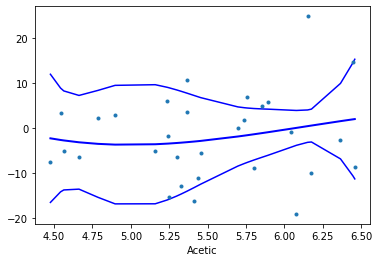

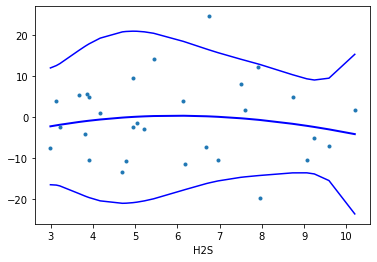

In [34]:
fig=gamod.plot_partial(0, cpr=True)
fig=gamod.plot_partial(1, cpr=True)

lam    0.671717
uci    0.406566
lci    0.972222
dtype: float64

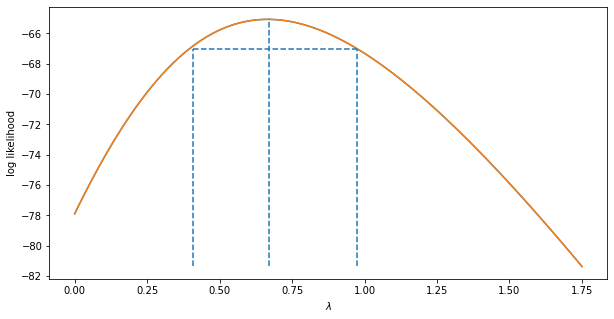

In [40]:
res, _ = boxcox_response(lmod, lam_range=(0, 1.75))
lam = res["lam"]
res

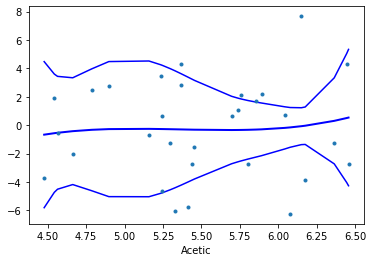

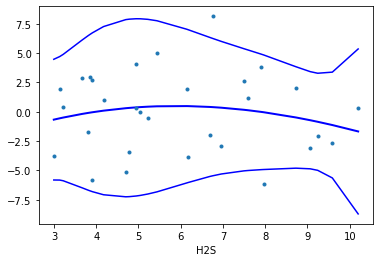

In [42]:
cheddar["taste_boxcox"] = sp.stats.boxcox(cheddar["taste"], lmbda=lam)

gamod_tr = GLMGam.from_formula(
    'taste_boxcox ~ Acetic + Lactic + H2S', 
    cheddar,
    smoother=bs
).fit()

fig=gamod_tr.plot_partial(0, cpr=True)
fig=gamod_tr.plot_partial(1, cpr=True)

In [43]:
cheddar.head()

,taste,Acetic,H2S,Lactic,Lactic_pertr,time,taste_boxcox
0,12.3,4.543,3.135,0.86,1.040009,0,6.545088
1,20.9,5.159,5.043,1.53,1.489272,1,9.981676
2,39.0,5.366,5.438,1.57,1.550854,2,15.951780
3,47.9,5.759,7.496,1.81,1.786209,3,18.534030
4,5.6,4.663,3.807,0.99,0.899213,4,3.246979


I have applied the transform, the plots seems to have not changed at all.